Compiling model...
Building feed-forward neural network...
'build' took 0.040979 s

'compile' took 0.286032 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.02e-01]    [1.02e-01]    []  
1000      [8.18e-07]    [8.18e-07]    []  
2000      [5.06e-07]    [5.06e-07]    []  
3000      [2.22e-07]    [2.22e-07]    []  
4000      [5.62e-08]    [5.62e-08]    []  
5000      [7.92e-07]    [7.92e-07]    []  
6000      [1.59e-08]    [1.59e-08]    []  
7000      [1.39e-08]    [1.39e-08]    []  
8000      [9.63e-09]    [9.63e-09]    []  
9000      [4.96e-07]    [4.96e-07]    []  
10000     [4.54e-09]    [4.54e-09]    []  

Best model at step 10000:
  train loss: 4.54e-09
  test loss: 4.54e-09
  test metric: []

'train' took 10.523450 s



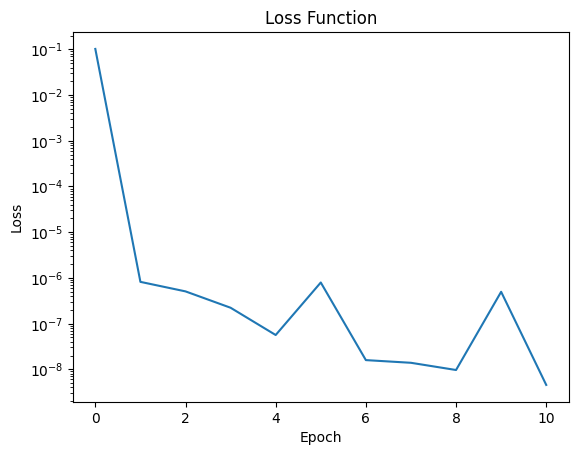

In [12]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import paddle.fluid as fluid

def pde(x, y, n1, n2):
    psi = y[:, 0:1]
    psi_conj = fluid.layers.conj(psi)
    psi_xx, psi_yy = dde.grad.hessian(y, x, component=0), dde.grad.hessian(y, x, component=1)
    eq1 = 1j * (n1**2 - n2**2) * psi + psi_xx + psi_yy - (n1**2 + n2**2) * psi_conj * psi
    eq2 = -1j * (n1**2 - n2**2) * psi_conj + psi_xx + psi_yy - (n1**2 + n2**2) * psi_conj * psi
    return eq1, eq2

def boundary_conditions(x, on_boundary):
    return on_boundary and (np.isclose(x[0], 1) or np.isclose(x[1], 1))

geom = dde.geometry.Rectangle([0, 0], [1, 1])
bc = dde.DirichletBC(geom, lambda x: np.zeros([len(x), 1]) ,boundary_conditions)
data = dde.data.PDE(geom, pde, [bc], num_domain=1000, num_boundary=100)
net = dde.maps.FNN([2] + [32]*3 + [2], "tanh", kernel_initializer="Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=10000)

# Plot the loss function
plt.figure()
plt.semilogy(losshistory.loss_test)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function")
plt.show()

# Plot the